<a href="https://colab.research.google.com/github/shreyas-sr/ML-learning/blob/main/Projects/P16_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Project: Image generation using convolutional GANs  



## Description

In this project, we will generate MNIST digits using GAN framework and CNNs. We will be using the architecture of DCGAN.

We will not focus much on GAN training but on CNNs and deep learning code writing in this notebook and GANs will not be a prerequisite. 

This project will give you a sense of the generative capabilities of deep learning using CNNs.

## Initialize and data handling

Lets import some libraries and get the data we will work with.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(0)
np.random.seed(0)

cuda:0


Set the batch size to 32 for train and 1 for test. Resize the images to 64 $\times$ 64 because DCGAN is optimized for those dimensions.

In [3]:
batch_size_train = 32
batch_size_test  = 1

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_data   = torchvision.datasets.MNIST(root='/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data    = torchvision.datasets.MNIST(root='/', train=False, transform=transform, download=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size_train, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



Initialize some parameters to be used in our code later.

In [4]:
# Number of channels in the training images. For MNIST data it is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 16  # try to vary to get optimal number

# Size of feature maps in generator
ngf = 8  # try to vary to get optimal number

# Size of feature maps in discriminator
ndf = 8  # try to vary to get optimal number

# Number of epochs
N_epochs = 10

# fixed latent vector to see how our output changes for these vectors during training
fixed_latent = torch.randn(16, nz, 1, 1).to(device)

## Network

Our generator is the network that generates images. We give a random noise called latent vector as input to the network and the generator gives us a MNIST digit as output.

The dimension of the latent vector is set to 16 in the cell above.

The vector is scaled using transposed convolutions which can be thought of as inverse of convolutions till it reaches the required 64 $\times$ 64 image.

Additionally, batch normalization is used to stabilize training.

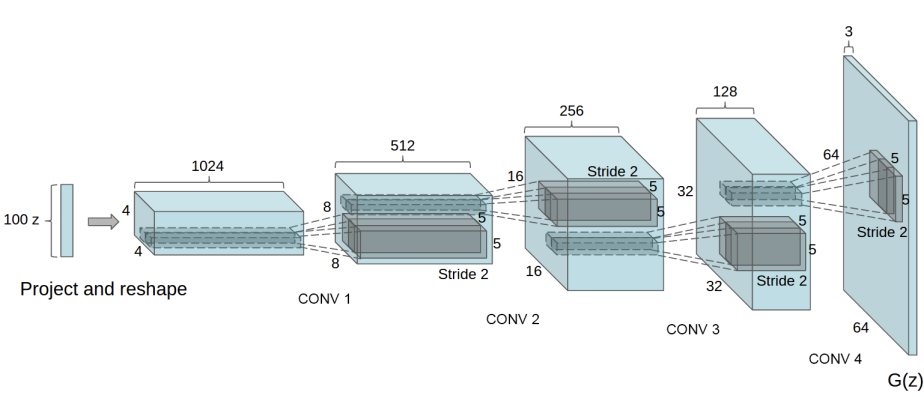

Documentation :

torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size = (ngf*8) x 4 x 4 = #out_channels * ((kernel_size*stride) * (kernel_size*stride)) 
            # Not / stride as this is inverse Convolution
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
generator = Generator().to(device)

The discriminator is just the opposite of the generator in architecture. Try to compare the two.

The target of the discriminator is to take in an image and predict whether it comes from the dataset or the generator. It outputs 1 if it thinks it comes from the dataset and 0 if it thinks it comes from the generator.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
discriminator = Discriminator().to(device)

Defining the optimizer below.

In [7]:
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

The loss function is given below.

The generator loss `criterion_g` tries to maximize it probability of fooling the discriminator.

Whereas the discriminator loss `criterion_d` tries to maximize the probability of catching the fakes produced by the generator.

`p` here denotes probability given by the disciminator.

In [8]:
def criterion_g(p_fake):
    return -torch.mean(torch.log(p_fake))

def criterion_d(p_real, p_fake):
    return -torch.mean(torch.log(p_real) + torch.log(1-p_fake))

## Training

The helper function below will plot the images produced by the generator as we proceed with the training.

In [9]:
def show_image_grid(images):
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.subplots_adjust(wspace=0.0, hspace=0.1)
    plt.show()

The training loop is given below.

We alternate the training of the discriminator and the generator. The generator produced some images and discriminator tries to distinguish between the reals and the fakes.

At the end of each epoch, we plot the images corresponding to the fixed latent defined above.

Epoch    0 | Train Loss g   3.1691 | Train Loss d   0.2621


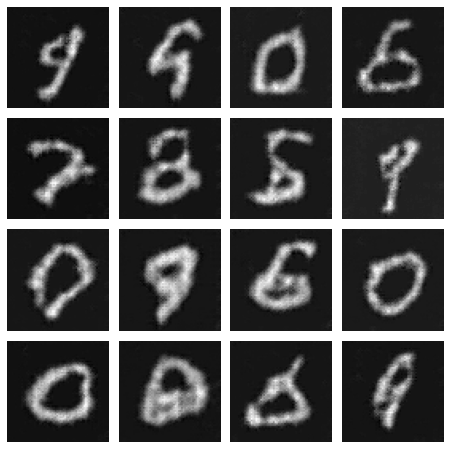

Epoch    1 | Train Loss g   2.7368 | Train Loss d   0.3535


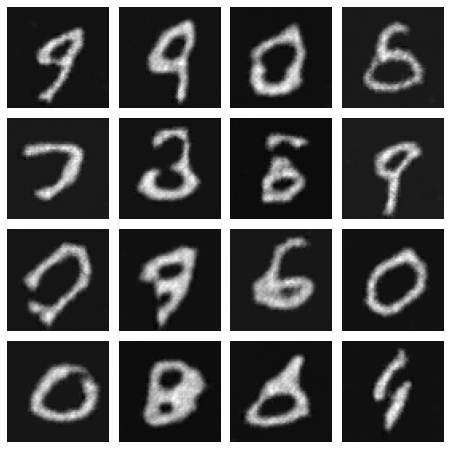

Epoch    2 | Train Loss g   2.7138 | Train Loss d   0.3639


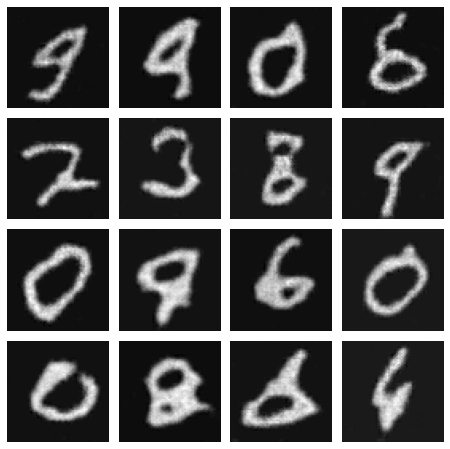

Epoch    3 | Train Loss g   2.7311 | Train Loss d   0.3654


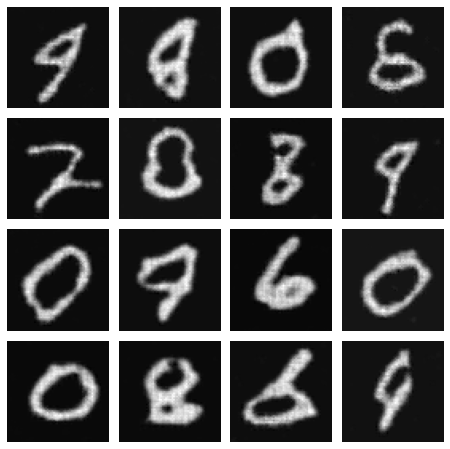

Epoch    4 | Train Loss g   2.7852 | Train Loss d   0.3621


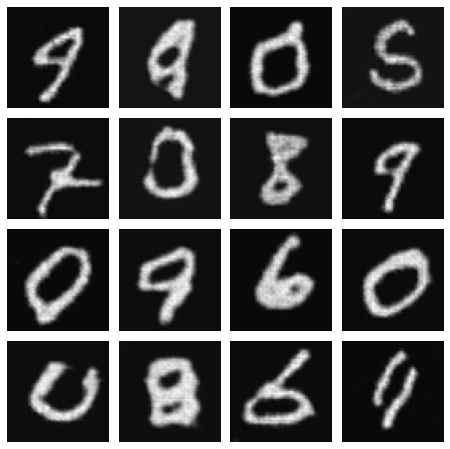

Epoch    5 | Train Loss g   2.8875 | Train Loss d   0.3517


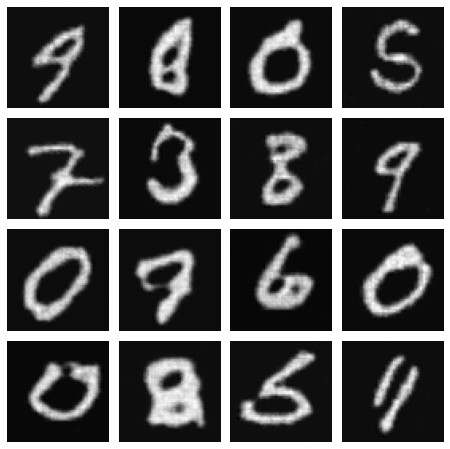

Epoch    6 | Train Loss g   2.9916 | Train Loss d   0.3348


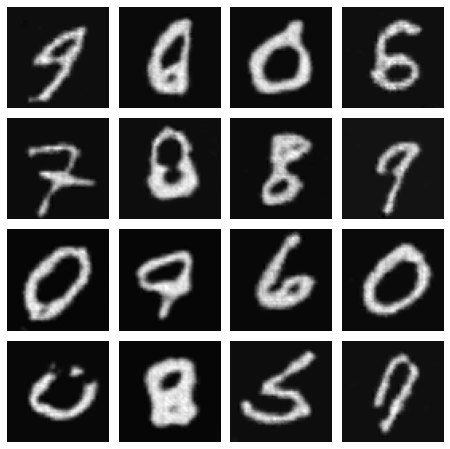

Epoch    7 | Train Loss g   3.1643 | Train Loss d   0.2956


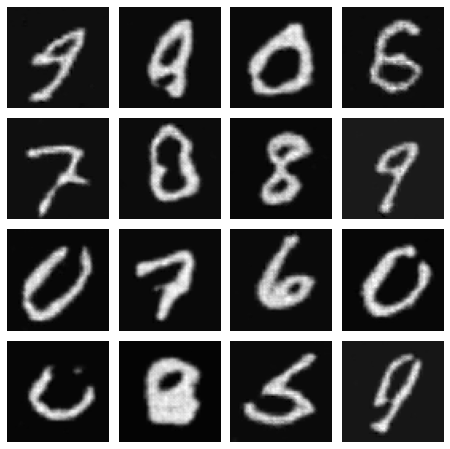

Epoch    8 | Train Loss g   3.4186 | Train Loss d   0.2559


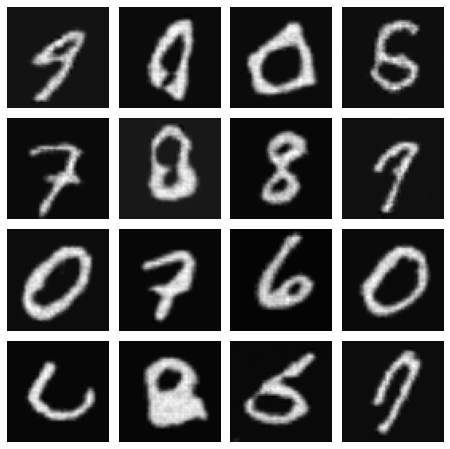

Epoch    9 | Train Loss g   3.5612 | Train Loss d   0.2541


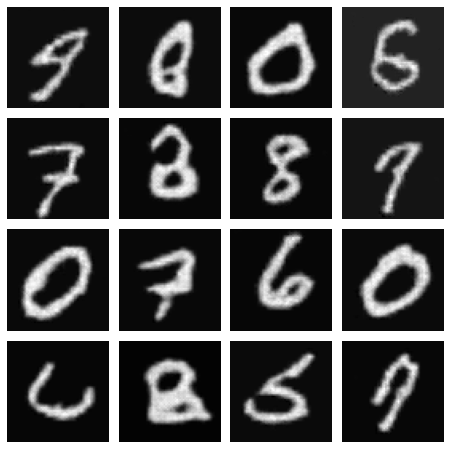

In [10]:
train_losses_g_epoch = []
train_losses_d_epoch = []
fixed_latent_outputs = []

for epoch in range(N_epochs):
    train_losses_g = []
    train_losses_d = []

    generator.train()
    discriminator.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        real = images.to(device)
        latent = torch.randn(batch_size_train, nz, 1, 1).to(device)
        fake = generator(latent)
        
        p_real = discriminator(real)
        p_fake = discriminator(fake) 
        loss_d = criterion_d(p_real, p_fake)        
        optimizer_d.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        p_fake = discriminator(fake)
        loss_g = criterion_g(p_fake)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        train_losses_g.append(loss_g.item())
        train_losses_d.append(loss_d.item())
    
    generator.eval()
    with torch.no_grad():
        fixed_latent_output = generator(fixed_latent)
        fixed_latent_output = fixed_latent_output.cpu().detach().numpy().reshape(-1,64,64)
        fixed_latent_outputs.append(fixed_latent_output)
    
    train_losses_g_epoch.append(sum(train_losses_g) / len(train_losses_g))
    train_losses_d_epoch.append(sum(train_losses_d) / len(train_losses_d))
    
    print('Epoch %4d | Train Loss g %8.4f | Train Loss d %8.4f' %
          (epoch, train_losses_g_epoch[-1], train_losses_d_epoch[-1]))
    
    show_image_grid(fixed_latent_output)

The loss curves are plotted below. Observe the the loss curve of GANs are not as interpretible as for other networks such as classifiers.

In [11]:
# TODO plot the generator and discriminator losses

In [12]:
train_losses_g_epoch

[3.1691293212215106,
 2.7367516060948374,
 2.713843594368299,
 2.731094065920512,
 2.7852181042989095,
 2.8875028626124064,
 2.991578766374787,
 3.164332634882132,
 3.4185857418696086,
 3.5612208481689294]

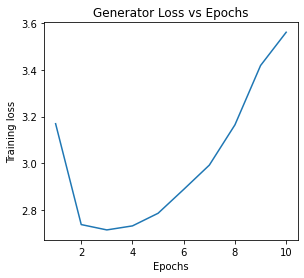

In [13]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses_g_epoch)+1),train_losses_g_epoch)
plt.ylabel('Training loss')
plt.xlabel('Epochs')
ax.set_title('Generator Loss vs Epochs')
plt.show()

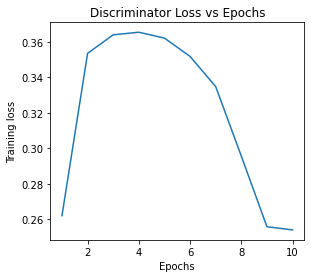

In [14]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses_d_epoch)+1),train_losses_d_epoch)
plt.ylabel('Training loss')
plt.xlabel('Epochs')
ax.set_title('Discriminator Loss vs Epochs')
plt.show()

Now, try producing some random digits by passing on random vectors to the generator.

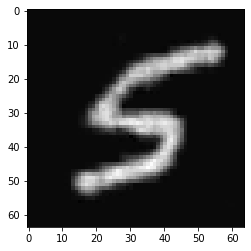

In [15]:
# run this cell multiple times to see new output produced each time
generator.eval()
with torch.no_grad():
    latent = torch.randn(1,nz,1,1).to(device)
    output = generator(latent).cpu().detach().numpy().reshape(64,64)
    plt.imshow(output, cmap='gray')
    plt.show()

## Exercise
1. Try varying the size of latent vector and report the quality of images procuded.

2. Change ndf and ngf to different values and see whether the GAN still produces good digits.

3. Increase the number of epochs and see whether the quality of GAN improves.

4. Interpolate between the latent vectors. Are the produced outputs also being interpolated?

### Helper code for the exercise

In [27]:
class Generator2(nn.Module):
    def __init__(self,nz,ngf,nc):
        super(Generator2, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=self.nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size = (ngf*8) x 4 x 4 = #out_channels * ((kernel_size*stride) * (kernel_size*stride)) 
            # Not / stride as this is inverse Convolution
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( self.ngf * 2, self.ngf, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( self.ngf, self.nc, 4, 2, 1, bias=False),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [43]:
def variationsGAN(nz = 16, ngf = 8, ndf = 8,N_epochs=10,lat = 16):

  batch_size_train = 32
  batch_size_test  = 1

  transform = transforms.Compose([
      transforms.Resize((64,64)),
      transforms.ToTensor(),
  ])

  train_data   = torchvision.datasets.MNIST(root='/', train=True, transform=transform, download=True)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

  test_data    = torchvision.datasets.MNIST(root='/', train=False, transform=transform, download=True)
  test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size_train, shuffle=True)

  # fixed latent vector to see how our output changes for these vectors during training
  fixed_latent = torch.randn(lat, nz, 1, 1).to(device)

  generator = Generator2(nz,ngf,nc).to(device)
  #print(generator.nz)
  discriminator = Discriminator().to(device)
  optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
  optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

  train_losses_g_epoch = []
  train_losses_d_epoch = []
  fixed_latent_outputs = []

  for epoch in range(N_epochs):
      train_losses_g = []
      train_losses_d = []

      generator.train()
      discriminator.train()
      for batch_idx, (images, _) in enumerate(train_loader):
          real = images.to(device)
          latent = torch.randn(batch_size_train, nz, 1, 1).to(device)
          fake = generator(latent)
          
          p_real = discriminator(real)
          p_fake = discriminator(fake) 
          loss_d = criterion_d(p_real, p_fake)        
          optimizer_d.zero_grad()
          loss_d.backward(retain_graph=True)
          optimizer_d.step()
          
          p_fake = discriminator(fake)
          loss_g = criterion_g(p_fake)
          optimizer_g.zero_grad()
          loss_g.backward()
          optimizer_g.step()
          
          train_losses_g.append(loss_g.item())
          train_losses_d.append(loss_d.item())
      
      generator.eval()
      with torch.no_grad():
          fixed_latent_output = generator(fixed_latent)
          fixed_latent_output = fixed_latent_output.cpu().detach().numpy().reshape(-1,64,64)
          fixed_latent_outputs.append(fixed_latent_output)
      
      train_losses_g_epoch.append(sum(train_losses_g) / len(train_losses_g))
      train_losses_d_epoch.append(sum(train_losses_d) / len(train_losses_d))
      
      print('Epoch %4d | Train Loss g %8.4f | Train Loss d %8.4f' %
            (epoch, train_losses_g_epoch[-1], train_losses_d_epoch[-1]))
      
      show_image_grid(fixed_latent_output)
  return [generator,train_losses_g_epoch,train_losses_d_epoch]

In [16]:
def plotLosses(train_losses_g_epoch,train_losses_d_epoch):
  fig = plt.figure(figsize=(10,4))
  ax = fig.add_subplot(1,2, 1)
  ax.plot(np.arange(1,len(train_losses_g_epoch)+1),train_losses_g_epoch)
  plt.ylabel('Training loss')
  plt.xlabel('Epochs')
  ax.set_title('Generator Loss vs Epochs')
  plt.show()

  fig = plt.figure(figsize=(10,4))
  ax = fig.add_subplot(1,2, 2)
  ax.plot(np.arange(1,len(train_losses_d_epoch)+1),train_losses_d_epoch)
  plt.ylabel('Training loss')
  plt.xlabel('Epochs')
  ax.set_title('Discriminator Loss vs Epochs')
  plt.show()

### 1. Different size latent vector

Epoch    0 | Train Loss g   3.9211 | Train Loss d   0.1633


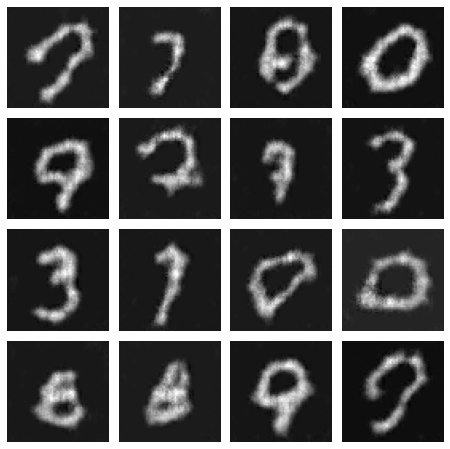

Epoch    1 | Train Loss g   2.8005 | Train Loss d   0.3476


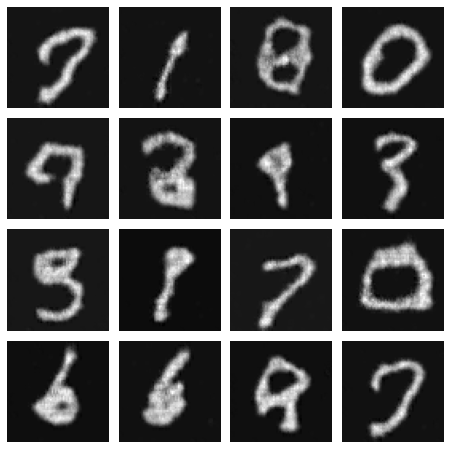

Epoch    2 | Train Loss g   2.7218 | Train Loss d   0.3824


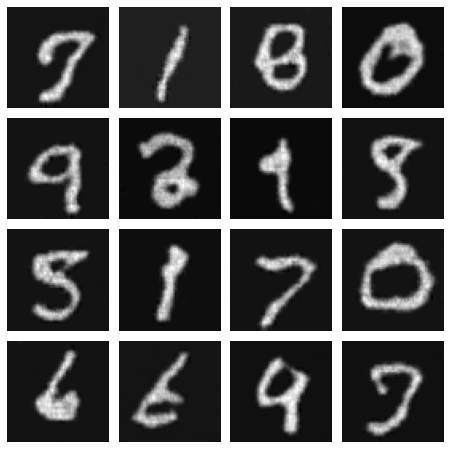

Epoch    3 | Train Loss g   3.2312 | Train Loss d   0.3109


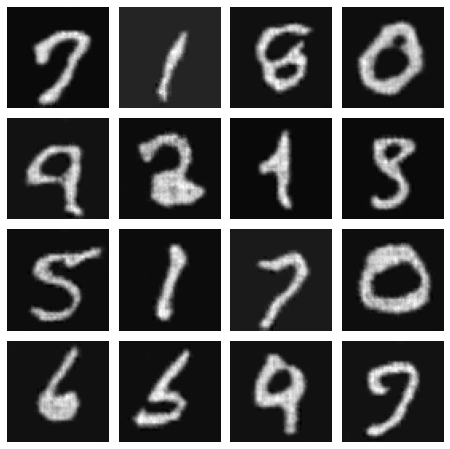

Epoch    4 | Train Loss g   3.0260 | Train Loss d   0.3149


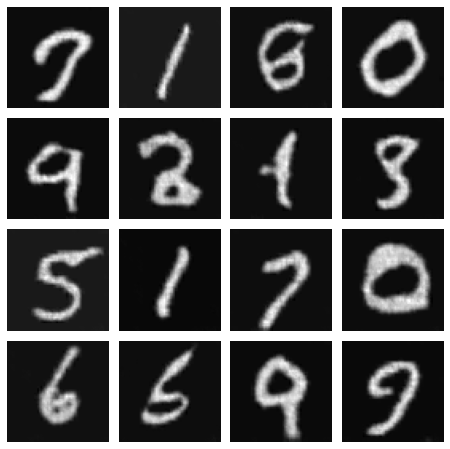

Epoch    5 | Train Loss g   3.1895 | Train Loss d   0.3052


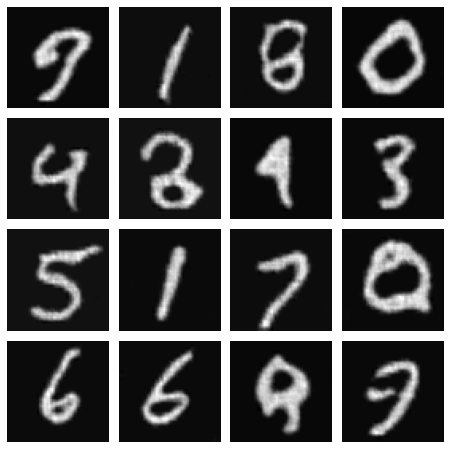

Epoch    6 | Train Loss g   3.4051 | Train Loss d   0.2642


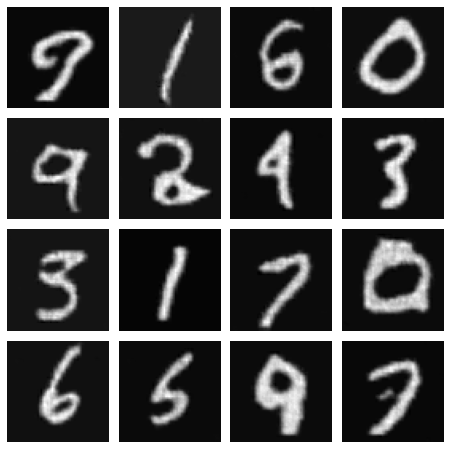

Epoch    7 | Train Loss g   3.4767 | Train Loss d   0.2489


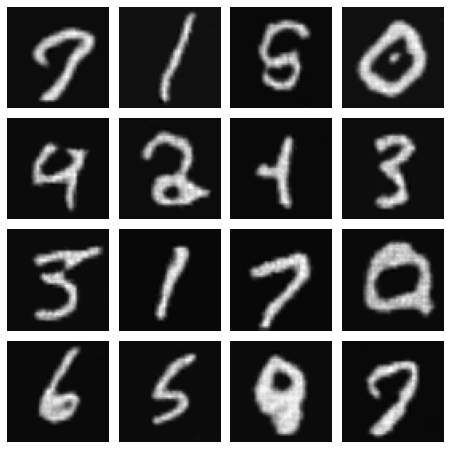

Epoch    8 | Train Loss g   3.6332 | Train Loss d   0.2321


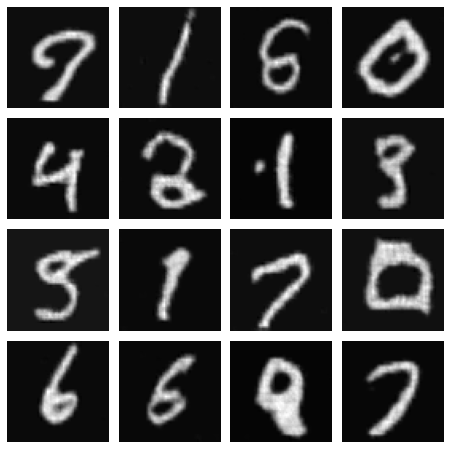

Epoch    9 | Train Loss g   3.7831 | Train Loss d   0.2186


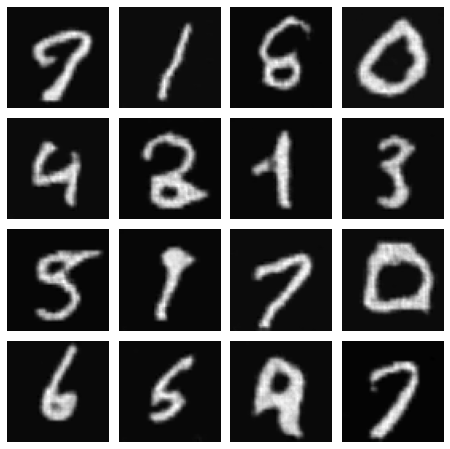

In [44]:
gen1, tLoss_d1, tLoss_g1 = variationsGAN(nz = 32, ngf = 8, ndf = 8,N_epochs=10)

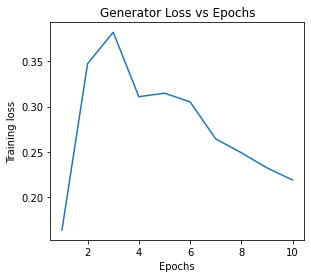

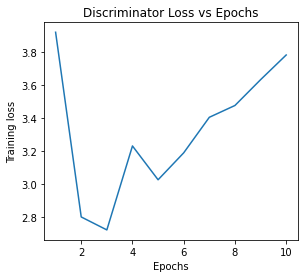

In [45]:
plotLosses(tLoss_g1,tLoss_d1)

### 2. Change ngf, ndf

Epoch    0 | Train Loss g   2.6291 | Train Loss d   0.3885


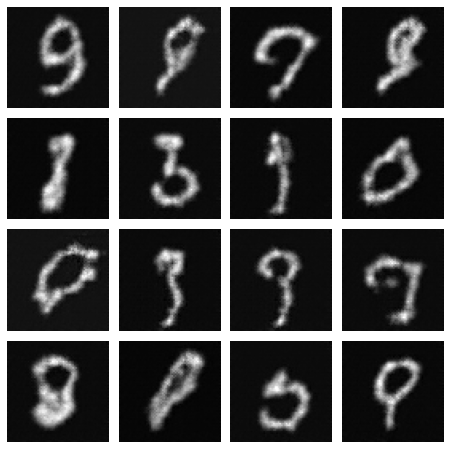

Epoch    1 | Train Loss g   2.4085 | Train Loss d   0.4541


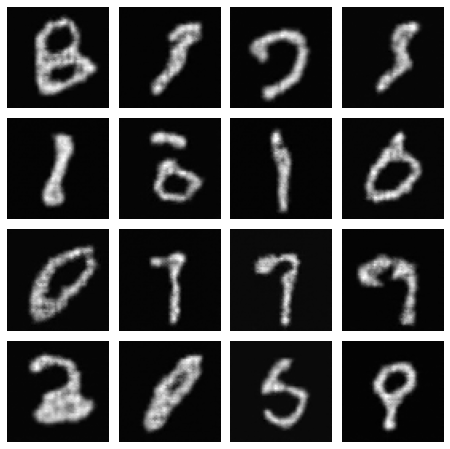

Epoch    2 | Train Loss g   2.6590 | Train Loss d   0.3869


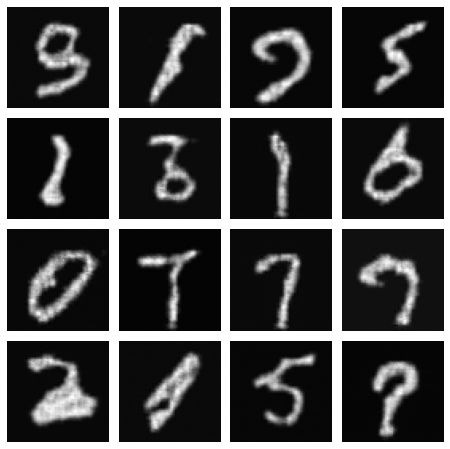

Epoch    3 | Train Loss g   2.9095 | Train Loss d   0.3435


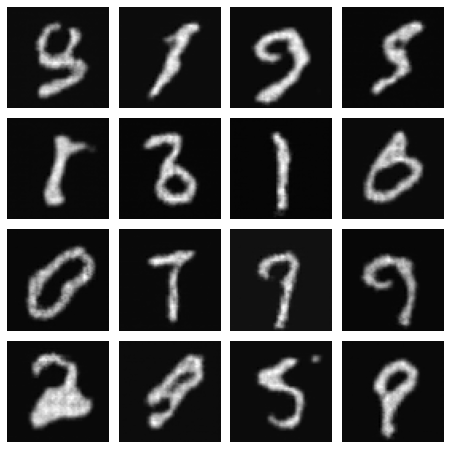

Epoch    4 | Train Loss g   3.7462 | Train Loss d   0.2252


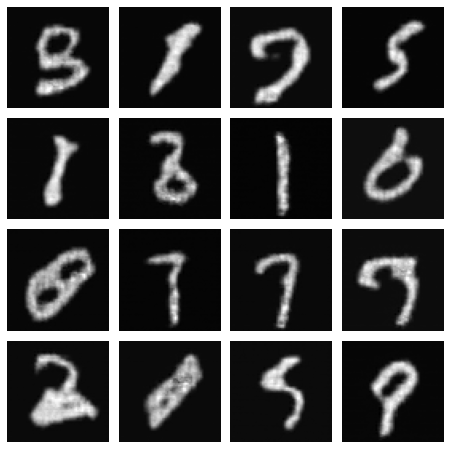

Epoch    5 | Train Loss g   4.9138 | Train Loss d   0.1307


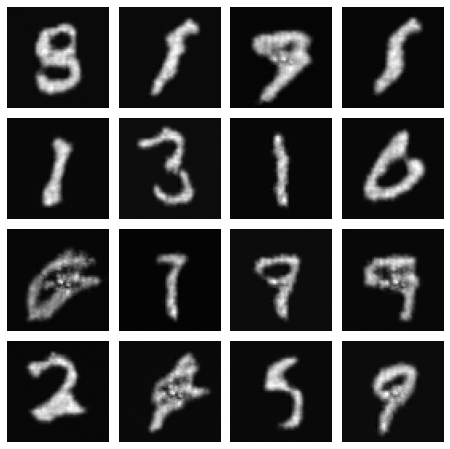

Epoch    6 | Train Loss g   5.5223 | Train Loss d   0.1219


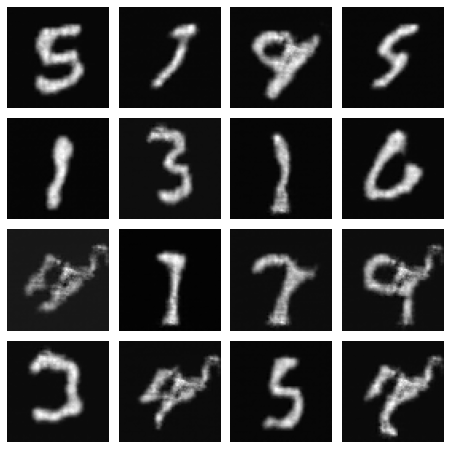

Epoch    7 | Train Loss g   6.0959 | Train Loss d   0.0682


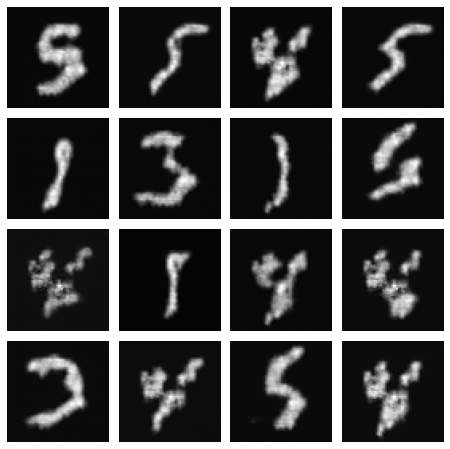

Epoch    8 | Train Loss g   6.4669 | Train Loss d   0.0657


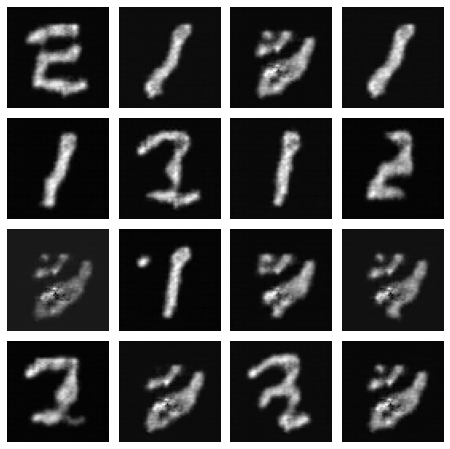

Epoch    9 | Train Loss g   6.9825 | Train Loss d   0.0340


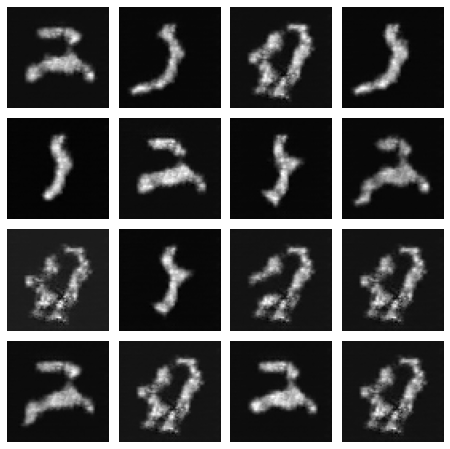

In [31]:
gen2, tLoss_d2, tLoss_g2 = variationsGAN(nz = 16, ngf = 16, ndf = 16,N_epochs=10)

In [ ]:
plotLosses(tLoss_g2,tLoss_d2)

### 3. Different epochs

Epoch    0 | Train Loss g   4.0144 | Train Loss d   0.1511


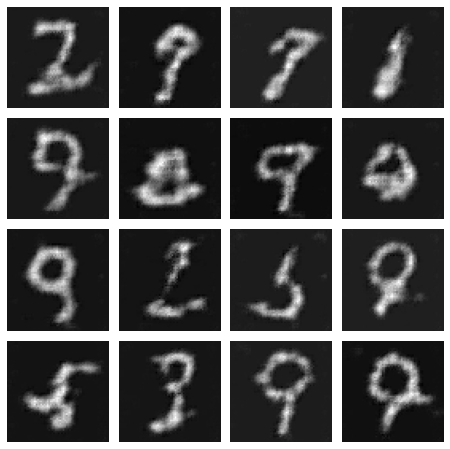

Epoch    1 | Train Loss g   3.1618 | Train Loss d   0.2832


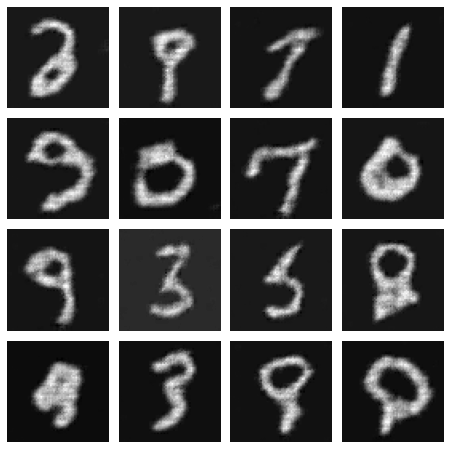

Epoch    2 | Train Loss g   2.6748 | Train Loss d   0.3916


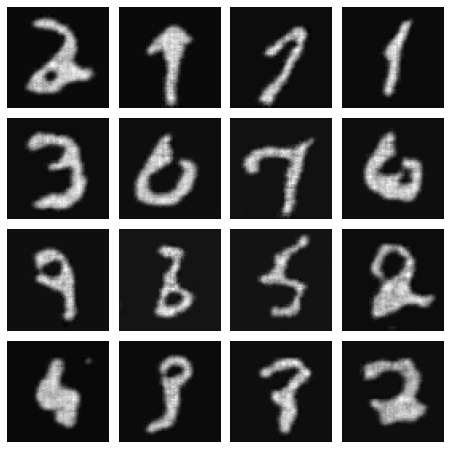

Epoch    3 | Train Loss g   2.7428 | Train Loss d   0.3849


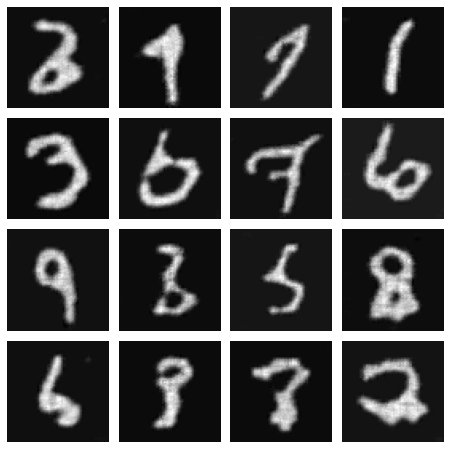

Epoch    4 | Train Loss g   3.1982 | Train Loss d   0.3017


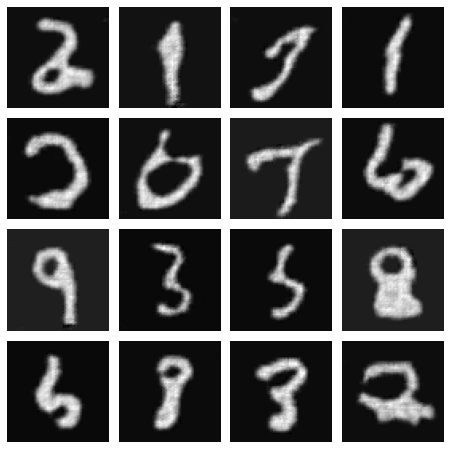

Epoch    5 | Train Loss g   3.6487 | Train Loss d   0.2535


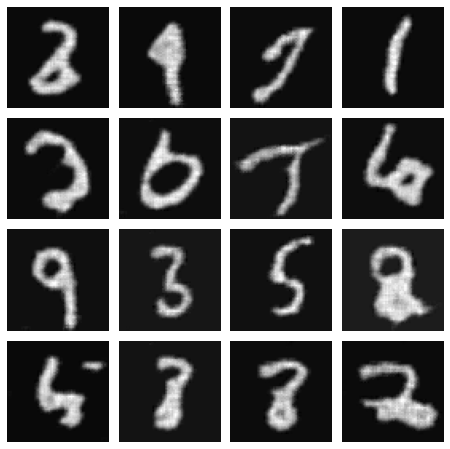

Epoch    6 | Train Loss g   3.7224 | Train Loss d   0.2407


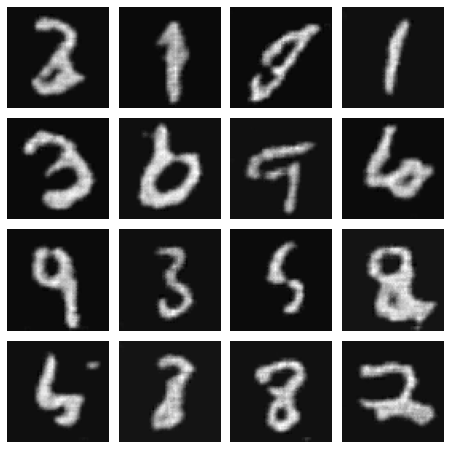

Epoch    7 | Train Loss g   4.0122 | Train Loss d   0.2048


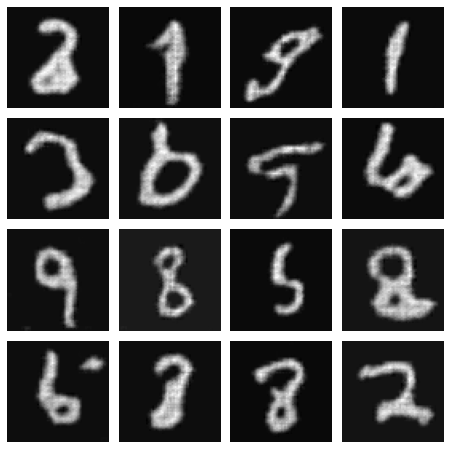

Epoch    8 | Train Loss g   4.1464 | Train Loss d   0.1662


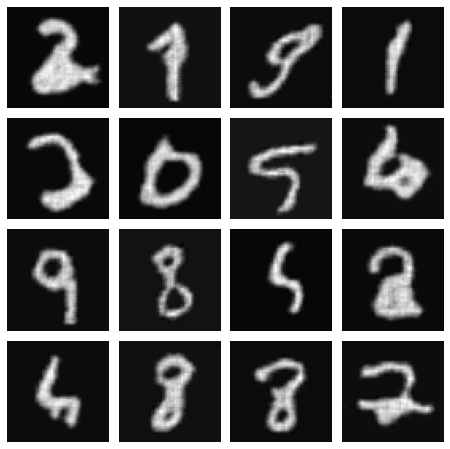

Epoch    9 | Train Loss g   4.1194 | Train Loss d   0.2051


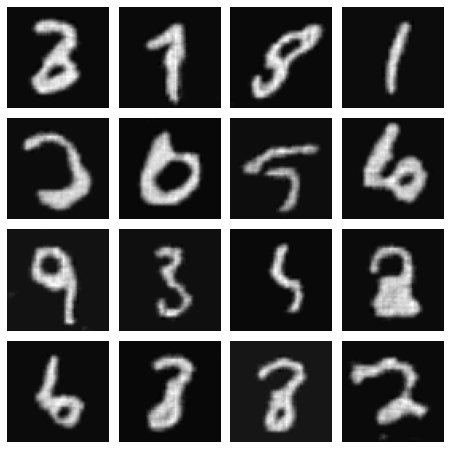

Epoch   10 | Train Loss g   4.2841 | Train Loss d   0.1711


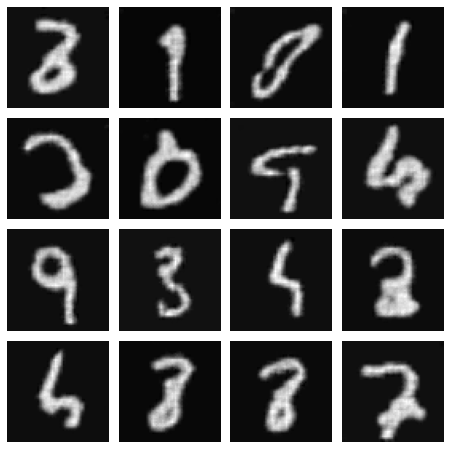

Epoch   11 | Train Loss g   4.2741 | Train Loss d   0.1907


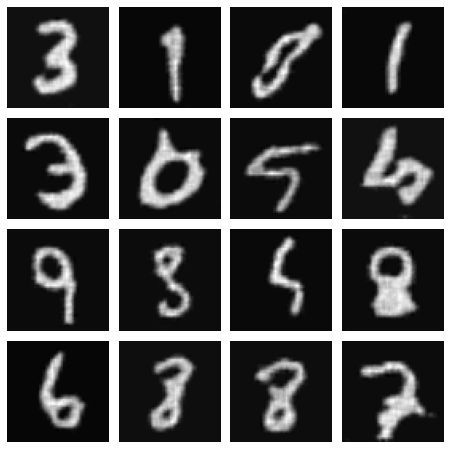

Epoch   12 | Train Loss g   4.5071 | Train Loss d   0.1503


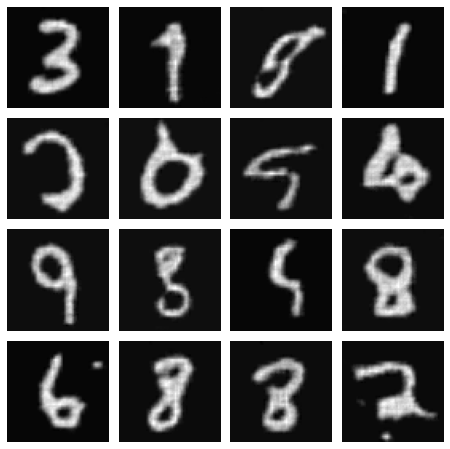

Epoch   13 | Train Loss g   4.5825 | Train Loss d   0.1495


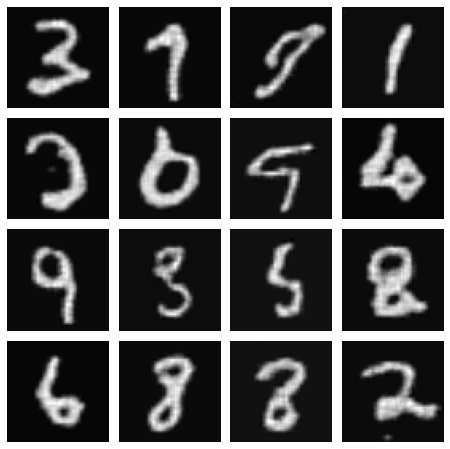

Epoch   14 | Train Loss g   4.7348 | Train Loss d   0.1258


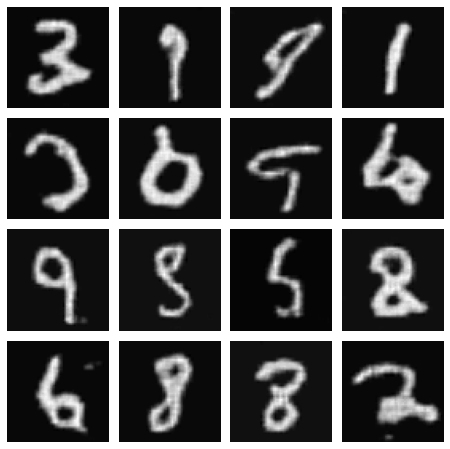

Epoch   15 | Train Loss g   4.8042 | Train Loss d   0.1397


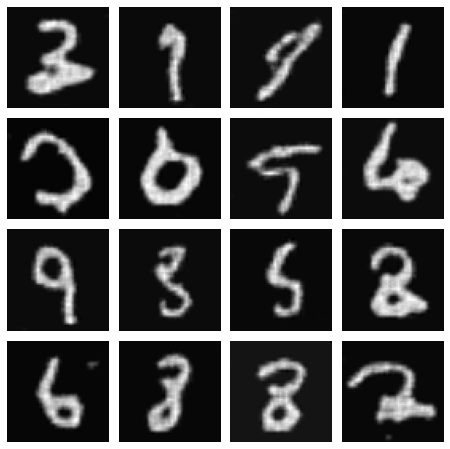

Epoch   16 | Train Loss g   4.6946 | Train Loss d   0.1491


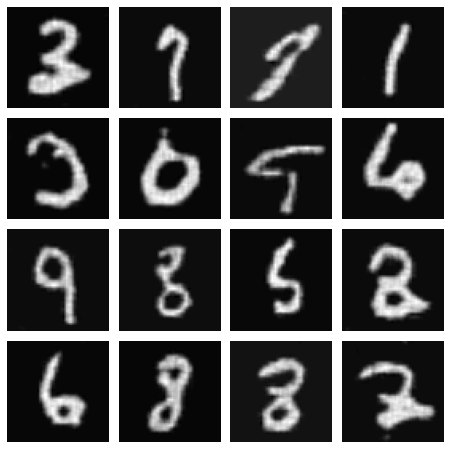

Epoch   17 | Train Loss g   4.8255 | Train Loss d   0.1401


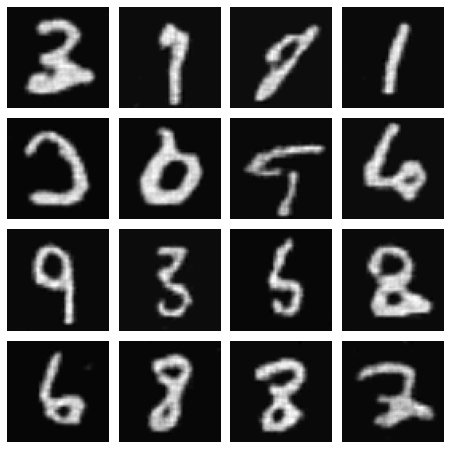

Epoch   18 | Train Loss g   4.7897 | Train Loss d   0.1284


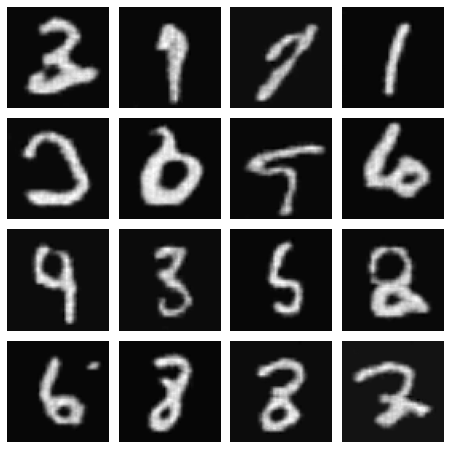

Epoch   19 | Train Loss g   4.6468 | Train Loss d   0.1596


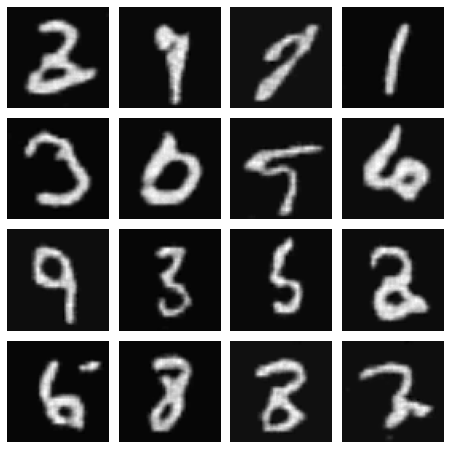

In [33]:
gen3, tLoss_d3, tLoss_g3 = variationsGAN(nz = 16, ngf = 8, ndf = 8,N_epochs=20)

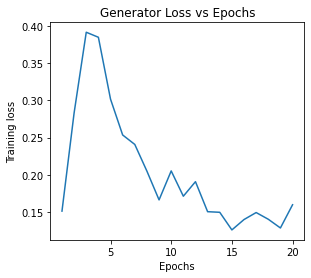

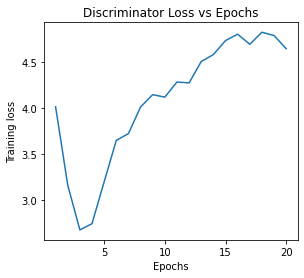

In [34]:
plotLosses(tLoss_g3,tLoss_d3)

### 4. Interpolate latent vectors

Epoch    0 | Train Loss g   2.9491 | Train Loss d   0.2956


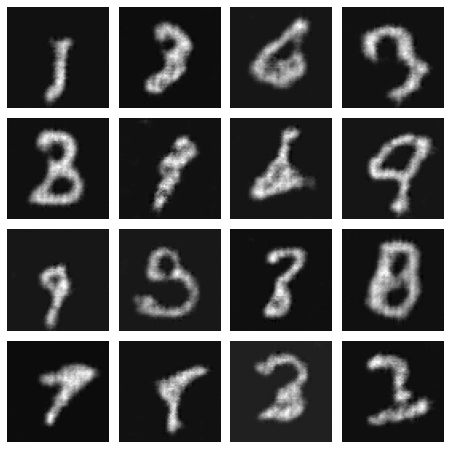

Epoch    1 | Train Loss g   2.3152 | Train Loss d   0.4916


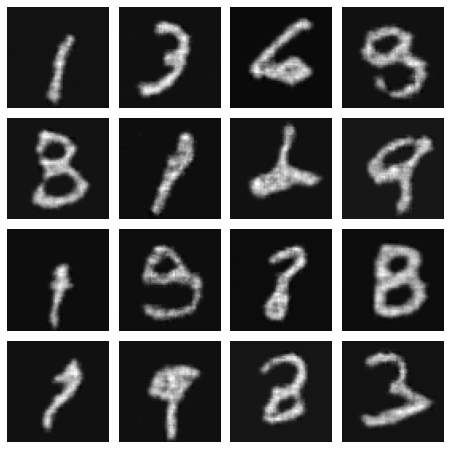

Epoch    2 | Train Loss g   2.4301 | Train Loss d   0.4421


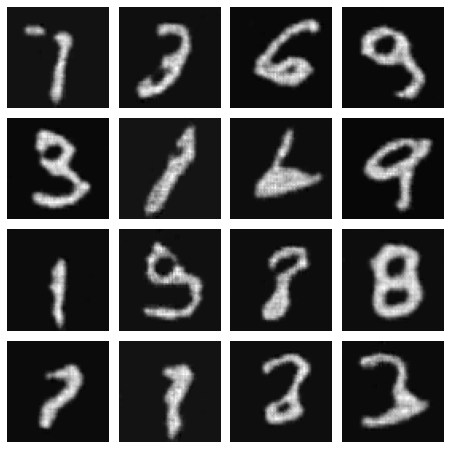

Epoch    3 | Train Loss g   2.4852 | Train Loss d   0.4483


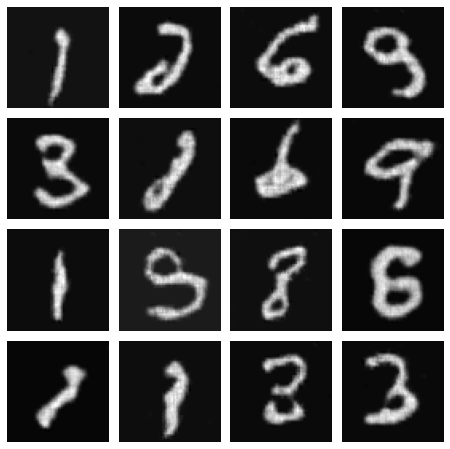

Epoch    4 | Train Loss g   2.7185 | Train Loss d   0.3862


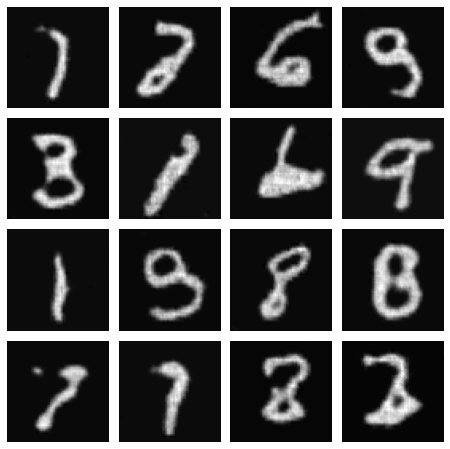

Epoch    5 | Train Loss g   2.9761 | Train Loss d   0.3319


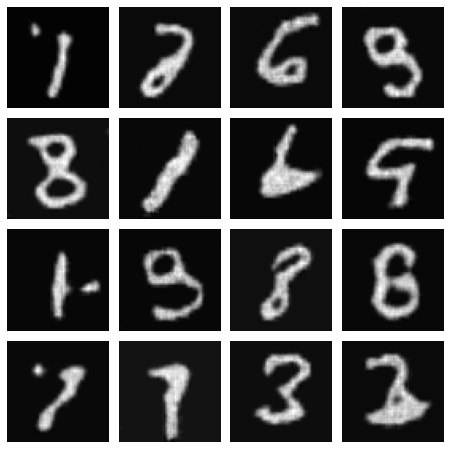

Epoch    6 | Train Loss g   3.3329 | Train Loss d   0.2667


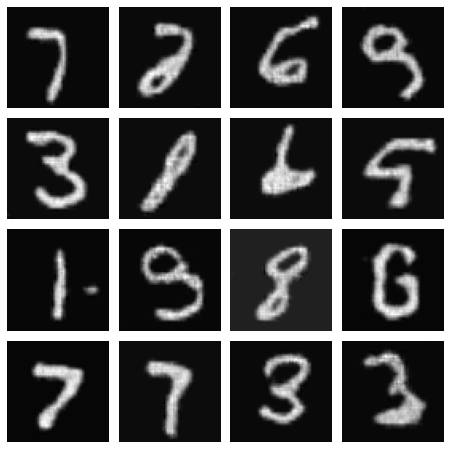

Epoch    7 | Train Loss g   3.5101 | Train Loss d   0.2343


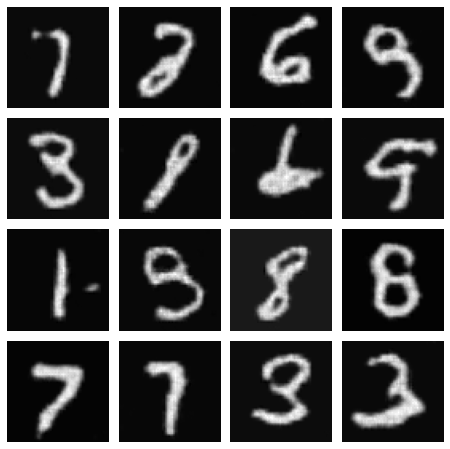

Epoch    8 | Train Loss g   3.6729 | Train Loss d   0.2353


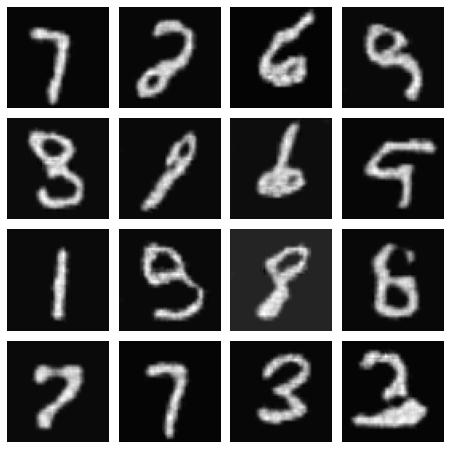

Epoch    9 | Train Loss g   3.7029 | Train Loss d   0.2274


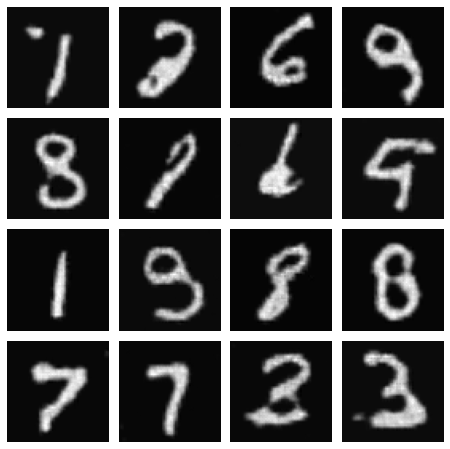

In [37]:
gen4, tLoss_d4, tLoss_g4 = variationsGAN(nz = 16, ngf = 8, ndf = 8,N_epochs=10,lat=32) #32 was 16

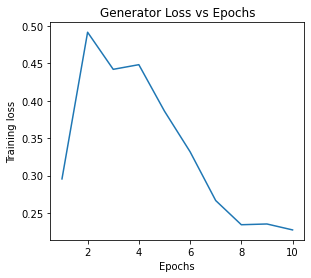

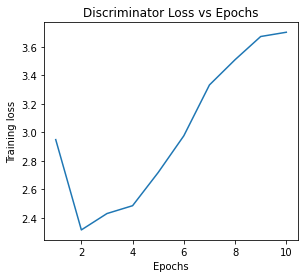

In [38]:
plotLosses(tLoss_g4,tLoss_d4)